In [101]:
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

# Algorithms
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model saving
import pickle


In [102]:
paths = "New folder\\"
file_names = ['bangalore_cars.xlsx', 'chennai_cars.xlsx', 'delhi_cars.xlsx',
              'hyderabad_cars.xlsx', 'jaipur_cars.xlsx', 'kolkata_cars.xlsx']
dfs = []
 
for file in file_names:
    df = pd.read_excel(f"{paths}{file}")
   
    state = os.path.splitext(file)[0].split('_')[0]
   
    df['state'] = state
   
    dfs.append(df)
 
merged_df = pd.concat(dfs, ignore_index=True)
 
print("Files merged successfully. Output saved as 'merged_cars_data.xlsx'")

Files merged successfully. Output saved as 'merged_cars_data.xlsx'


In [103]:
car_columns = ['new_car_detail',"new_car_overview","new_car_feature", "new_car_specs"]
 
def first_columns(car_data):
    Ft_clo_list = []
    for i in car_data:
        a = ast.literal_eval(i)
        Ft_clo_list.append(a)
    df = pd.DataFrame(Ft_clo_list)
    return df    
 
 
 
def four_column(car_data):
 
    def convert_to_dict(row):
        try:
            return ast.literal_eval(row)
        except ValueError:
            return None

    data_as_dicts = [convert_to_dict(row) for row in car_data]
 
    def extract_key_value_pairs(d):
        flat_dict = {}
        try:
            if 'top' in d:
                for item in d['top']:
                    key = item['key'] 
                    value = item['value']   
                    flat_dict[key] = value
        except:
             pass

        try:
            if 'data' in d:
                for section in d['data']:
                    if 'list' in section:
                        for item in section['list']:
                            key = item['key']   
                            value = item['value']  
                            flat_dict[key] = value
        except:
            pass        
       
        return flat_dict
 
    flattened_data = [extract_key_value_pairs(d) for d in data_as_dicts if d is not None]
    
    df = pd.DataFrame(flattened_data)
    return df

In [104]:
final_df = pd.DataFrame()
 
# List of car columns (assumed to be correct)
car_columns = ['new_car_detail', 'new_car_overview', 'new_car_feature', 'new_car_specs']
 
# Assuming `merged_df` is the merged DataFrame that you have already created
for i in range(len(car_columns)):
    if i == 0:
        w = first_columns(merged_df[car_columns[i]])  
    elif i>0:
        w = four_column(merged_df[car_columns[i]])   
 
    # Concatenate the current DataFrame 'w' with 'final_df'
    final_df = pd.concat([final_df, w], axis=1, ignore_index=False)  
final_df['city']=merged_df['state']
final_df.head()

,it,ft,bt,km,transmission,ownerNo,owner,oem,model,modelYear,...,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen,city
0,0,Petrol,Hatchback,"1,20,000",Manual,3,3rd Owner,Maruti,Maruti Celerio,2015,...,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5,235-litres,NaN,NaN,NaN,bangalore
1,0,Petrol,SUV,"32,706",Manual,2,2nd Owner,Ford,Ford Ecosport,2018,...,Drum,NaN,NaN,"Tubeless,Radial",4,352-litres,16,16,NaN,bangalore
2,0,Petrol,Hatchback,"11,949",Manual,1,1st Owner,Tata,Tata Tiago,2018,...,Drum,150 kmph,14.3 Seconds,Tubeless,5,242-litres,14,14,NaN,bangalore
3,0,Petrol,Sedan,"17,794",Manual,1,1st Owner,Hyundai,Hyundai Xcent,2014,...,Drum,172km/hr,14.2 Seconds,"Tubeless,Radial",4,407-litres,14,14,NaN,bangalore
4,0,Diesel,SUV,"60,000",Manual,1,1st Owner,Maruti,Maruti SX4 S Cross,2015,...,Solid Disc,190 Kmph,12 Seconds,"Tubeless,Radial",5,353-litres,16,16,NaN,bangalore


In [105]:
final_df.columns

Index(['it', 'ft', 'bt', 'km', 'transmission', 'ownerNo', 'owner', 'oem',
       'model', 'modelYear', 'centralVariantId', 'variantName', 'price',
       'priceActual', 'priceSaving', 'priceFixedText', 'trendingText',
       'Registration Year', 'Insurance Validity', 'Fuel Type', 'Seats',
       'Kms Driven', 'RTO', 'Ownership', 'Engine Displacement', 'Transmission',
       'Year of Manufacture', 'Mileage', 'Engine', 'Max Power', 'Torque',
       'Seats', 'Color', 'Engine Type', 'Displacement', 'Max Torque',
       'No of Cylinder', 'Values per Cylinder', 'Value Configuration',
       'Fuel Suppy System', 'BoreX Stroke', 'Compression Ratio',
       'Turbo Charger', 'Super Charger', 'Length', 'Width', 'Height',
       'Wheel Base', 'Front Tread', 'Rear Tread', 'Kerb Weight',
       'Gross Weight', 'Gear Box', 'Drive Type', 'Seating Capacity',
       'Steering Type', 'Turning Radius', 'Front Brake Type',
       'Rear Brake Type', 'Top Speed', 'Acceleration', 'Tyre Type',
       'No Door 

In [106]:
# Import necessary libraries
import re
import numpy as np
import pandas as pd
 
# Create a copy of the final dataframe
df = final_df.copy()
 
df_columns = df.columns
for i,k in df.isna().sum().items():
    if k >= 300:
        df.drop(i, axis=1, inplace=True)
df_columns_1 = df.columns
print(len(df_columns),len(df_columns_1))
 

 
 
conversion_factor = 1.39
df['Mileage'] = df['Mileage'].str.replace(' kmpl', '')
df['Mileage'] = df['Mileage'].apply(lambda x: float(x.replace(' km/kg', '')) * conversion_factor if 'km/kg' in str(x) else float(x))
df['Mileage'] = df['Mileage'].astype(float)
 
def extract_integer(value):
    result = re.findall(r'\d+', str(value))
    return int(result[0]) if result else None
 
 
df['km'] = df['km'].str.replace(',', '').astype(int)
 
#dropping duplicate columns
df = df.drop(["priceActual","priceSaving","Year of Manufacture","Seats","Fuel Type","trendingText","owner","Ownership","Kms Driven","transmission",'Engine Displacement','Displacement','Max Torque','centralVariantId','Engine Type'], axis=1)
 
df['Insurance Validity'] = df['Insurance Validity'].replace({
    'Third Party insurance': 'Third Party',
    '1': 'Not Available',
    '2': 'Not Available',
})
 
df['Gear Box'] = df['Gear Box'].str.strip()
df['Gear Box'] = df['Gear Box'].replace({
    '5-Speed': '5 Speed', '5-Speed`': '5 Speed', '5-Speed ': '5 Speed',
    '5 speed': '5 Speed', '5-Speed ': '5 Speed',
    'Six Speed Manual': '6 Speed', 'Six Speed': '6 Speed', '6-Speed': '6 Speed',
    '6-Speed IVT': '6 Speed IVT', 'Six Speed Automatic Transmission': '6 Speed',
    '6Speed': '6 Speed', 'Six Speed  Gearbox': '6 Speed', '6-speed': '6 Speed',
    'Five Speed': '5 Speed', 'Five Speed Manual': '5 Speed',
    'Five Speed Manual Transmission': '5 Speed', 'Five Speed Manual Transmission Gearbox': '5 Speed',
    '7-Speed': '7 Speed', '7-speed': '7 Speed',
    'Seven Speed': '7 Speed', '7-speed PDK': '7 Speed',
    '7G-DCT': '7 Speed DCT', '7-Speed DCT': '7 Speed DCT',
    '8-Speed': '8 Speed', '8-speed': '8 Speed',
    '8Speed': '8 Speed', '8-Speed DCT': '8 Speed',
    '9-Speed': '9 Speed', '9-speed': '9 Speed',
    '10-speed': '10 Speed',
    'Fully Automatic': 'Automatic', 'Single-speed transmission': 'Single Speed',
    'Single speed reduction gear': 'Single Speed', 'Single Speed': 'Single Speed',
    'SPEEDSHIFT TCT 9G': '9 Speed', '9G-TRONIC': '9 Speed',
    '9G TRONIC': '9 Speed', '9G-TRONIC automatic': '9 Speed',
    'AGS': 'Automatic', 'IVT': 'IVT', 'E-CVT': 'CVT', 'eCVT': 'CVT',
    'AMG SPEEDSHIFT DCT 8G': '8 Speed DCT', 'AMG 7-SPEED DCT': '7 Speed DCT',
    '10 Speed': '10 Speed'
})
 
df['Engine'] = df['Engine'].str.replace(' CC', '').astype(float)
 
df['Max Power'] = df['Max Power'].apply(extract_integer)
 
df['Torque'] = df['Torque'].apply(extract_integer)
 
df['Length'] = df['Length'].apply(extract_integer)
 
df['Width'] = df['Width'].apply(extract_integer)
 
df['Wheel Base'] = df['Wheel Base'].apply(extract_integer)
 
df['Height'] = df['Height'].apply(extract_integer)
 
df['Kerb Weight'] = df['Kerb Weight'].apply(extract_integer)

 
df['Registration Year'] = df['Registration Year'].apply(extract_integer)
 
df['Tyre Type'] = df['Tyre Type'].str.strip()
df['Tyre Type'] = df['Tyre Type'].replace({
    'Tubeless, Radial': 'Tubeless Radial', 'Tubeless,Radial': 'Tubeless Radial',
    'Radial, Tubless': 'Tubeless Radial', 'Radial, Tubeless': 'Tubeless Radial',
    'Tubeless Radial Tyres': 'Tubeless Radial', 'Tubless, Radial': 'Tubeless Radial',
    'Radial,Tubeless': 'Tubeless Radial', 'Tubeless,Radials': 'Tubeless Radial',
    'Tubeless, Runflat': 'Tubeless Runflat', 'Tubeless. Runflat': 'Tubeless Runflat',
    'Runflat Tyres': 'Runflat', 'Runflat Tyre': 'Runflat', 'Runflat,Radial': 'Runflat Radial',
    'Run-Flat': 'Runflat', 'Radial with tube': 'Radial Tube',
    'Radial Tubeless': 'Tubeless Radial', 'Tubeless Radials Tyre': 'Tubeless Radial',
    'Tubeless ': 'Tubeless', 'Radial ': 'Radial',
    'tubeless tyre': 'Tubeless', 'Tubeless Tyre': 'Tubeless',
    'Tubeless Tyres': 'Tubeless', 'Radial Tyres': 'Radial',
    'Tubeless Tyres, Radial': 'Tubeless Radial', 'Tubeless,Radial ': 'Tubeless Radial',
    'Tubeless Tyres Mud Terrain': 'Tubeless Mud Terrain',
    'Tubeless Tyres All Terrain': 'Tubeless All Terrain',
    'Tubeless Radials': 'Tubeless Radial','Tubeless,Runflat': 'Tubeless Runflat',
    'Tubless,Radial': 'Tubeless Radial', 'Radial Tube': 'Radial', 'Tubeless, Radials': 'Tubeless Radial'
   
})
 
def clean_price(price):
    price = price.replace(',', '').replace('₹', '').strip()
    try:
        if 'Lakh' in price:
            price = float(price.replace('Lakh', '').strip()) * 100000
        elif 'Crore' in price:
            price = float(price.replace('Crore', '').strip()) * 10000000
        else:
            price = float(price)
    except ValueError:
        return None
    return price
df['price'] = df['price'].apply(clean_price)
df['price'] = df['price'].astype(int)
 
 
#only mode
categorical_columns = [
 "ft","bt","ownerNo","oem","model","modelYear",
 "Registration Year","Insurance Validity","Transmission",
 "Engine","Color","No of Cylinder", "Values per Cylinder",
 "Gear Box","Seating Capacity","Steering Type","Front Brake Type",
 "Rear Brake Type","Tyre Type","No Door Numbers","city"]

#only avg
Numerical_columns = ["it","km","Mileage","Torque","Length","Width","Height","Wheel Base","Kerb Weight","Max Power"]
 
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])
 
for col in Numerical_columns:
    df[col] = df[col].fillna(df[col].mean())

68 49


In [107]:
df.isnull().sum()

it                     0
ft                     0
bt                     0
km                     0
ownerNo                0
oem                    0
model                  0
modelYear              0
variantName            0
price                  0
Registration Year      0
Insurance Validity     0
Transmission           0
Mileage                0
Engine                 0
Max Power              0
Torque                 0
Color                  0
No of Cylinder         0
Values per Cylinder    0
Length                 0
Width                  0
Height                 0
Wheel Base             0
Kerb Weight            0
Gear Box               0
Seating Capacity       0
Steering Type          0
Front Brake Type       0
Rear Brake Type        0
Tyre Type              0
No Door Numbers        0
city                   0
dtype: int64

In [108]:
# Define categorical and numerical columns
#for nominal
OneHotEncoding_columns = [
    'ft', 'bt', 'oem', 'model', 'Insurance Validity', 'Transmission',
    'Color', 'Gear Box', 'Steering Type', 
    'Front Brake Type', 'Rear Brake Type', 'Tyre Type', 'city','variantName'
]
#ordinal columns
# Original categorical columns for label encoding
label_encoding_columns = [
    'Engine', 'No of Cylinder', 'Values per Cylinder', 
    'Seating Capacity', 'No Door Numbers', 'ownerNo', 
    'modelYear', 'Registration Year'
]

numerical_columns = [
    "it","km", "Mileage", "Torque", "Length", "Width", "Height",
    "Wheel Base", "Kerb Weight", "Max Power"
]

drop_columns = []

# Step 1: Split the data into train and test sets
X = df.drop(columns=['price'])  # Features
y = df['price']  # Target variable

In [109]:
numerical_column = X[numerical_columns]

variance = numerical_column.var()

low_variance_columns = variance[variance == 0].index.tolist()

print("Columns with low variance (variance = 0):", low_variance_columns)

drop_columns.append(low_variance_columns[0])
numerical_columns.remove(low_variance_columns[0])

Columns with low variance (variance = 0): ['it']


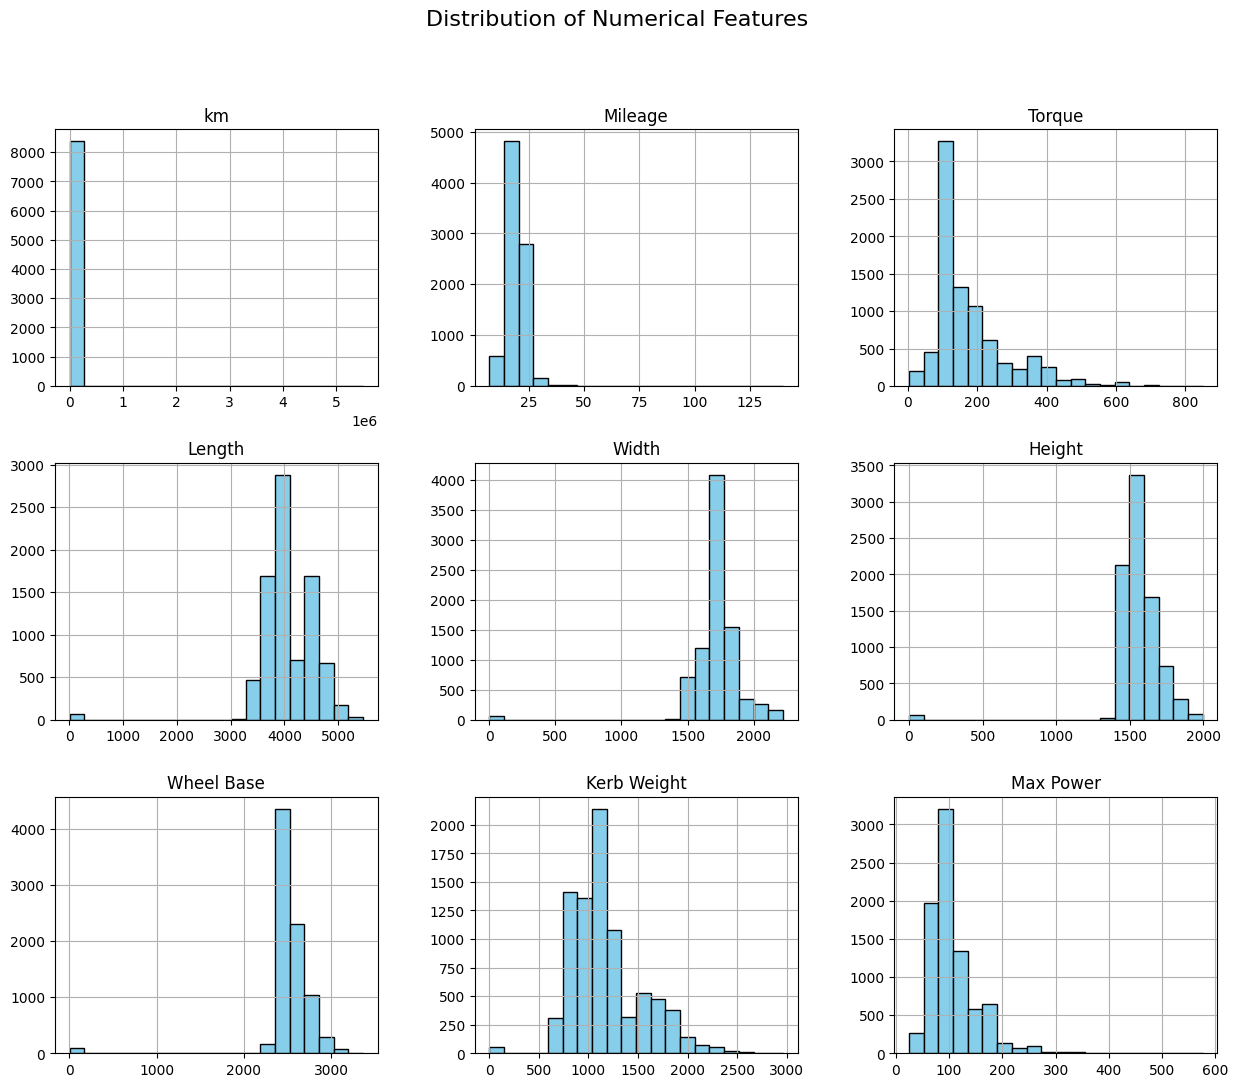

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting histograms for numerical columns
df[numerical_columns].hist(figsize=(15, 12), bins=20, color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.show()


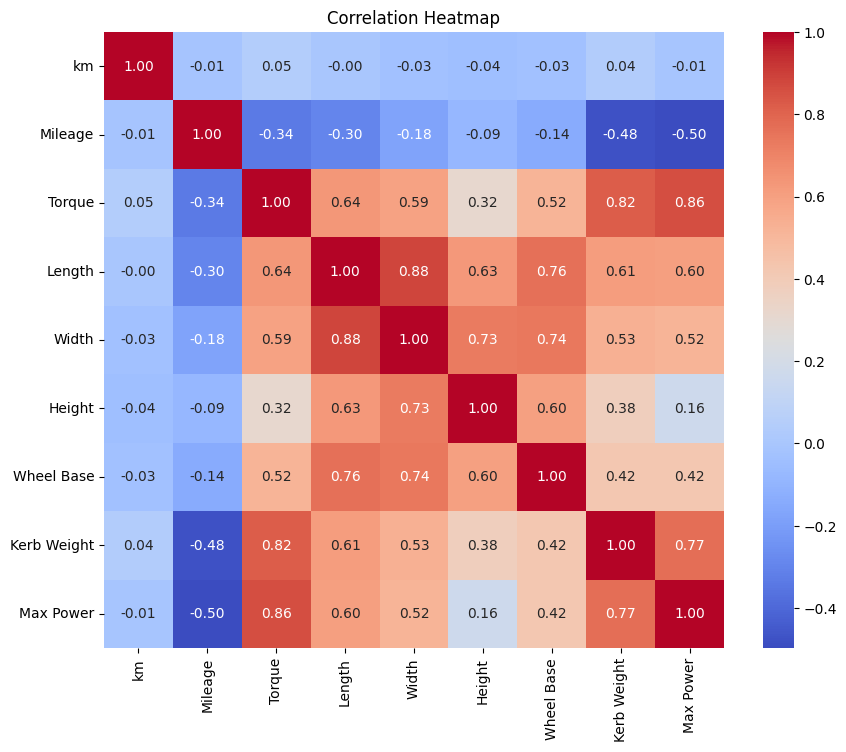

set()


In [111]:
# Select only numeric columns for correlation
numeric_df = X[numerical_columns]

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

numeric_df = X[numerical_columns]
corr_features = correlation(numeric_df, 0.9)

print(corr_features)


In [112]:

for i in corr_features:
    drop_columns.append(i)
    numerical_columns.remove(i)

In [113]:

X_corr = pd.DataFrame(X[numerical_columns])
# Add the target variable (price) to the DataFrame for correlation analysis
X_corr['price'] = y.values  # Assuming y_train is a Series containing the target variable

# Calculate the correlation of numerical features with the target variable (price)
correlation_with_price = X_corr[numerical_columns + ['price']].corr()['price']

# Display the correlations with the target variable
print("Correlation with price:\n", correlation_with_price)

# If you want to filter out features with low correlation (e.g., |correlation| < 0.2)
low_correlation_features = correlation_with_price[abs(correlation_with_price) < 0.1].index.tolist()
print("low correlated features with price (|correlation| < 0.1):", low_correlation_features)
for i in low_correlation_features:
    drop_columns.append(i)
    numerical_columns.remove(i)

Correlation with price:
 km            -0.077351
Mileage       -0.251518
Torque         0.647847
Length         0.396359
Width          0.382184
Height         0.153339
Wheel Base     0.320852
Kerb Weight    0.551311
Max Power      0.747575
price          1.000000
Name: price, dtype: float64
low correlated features with price (|correlation| < 0.1): ['km']


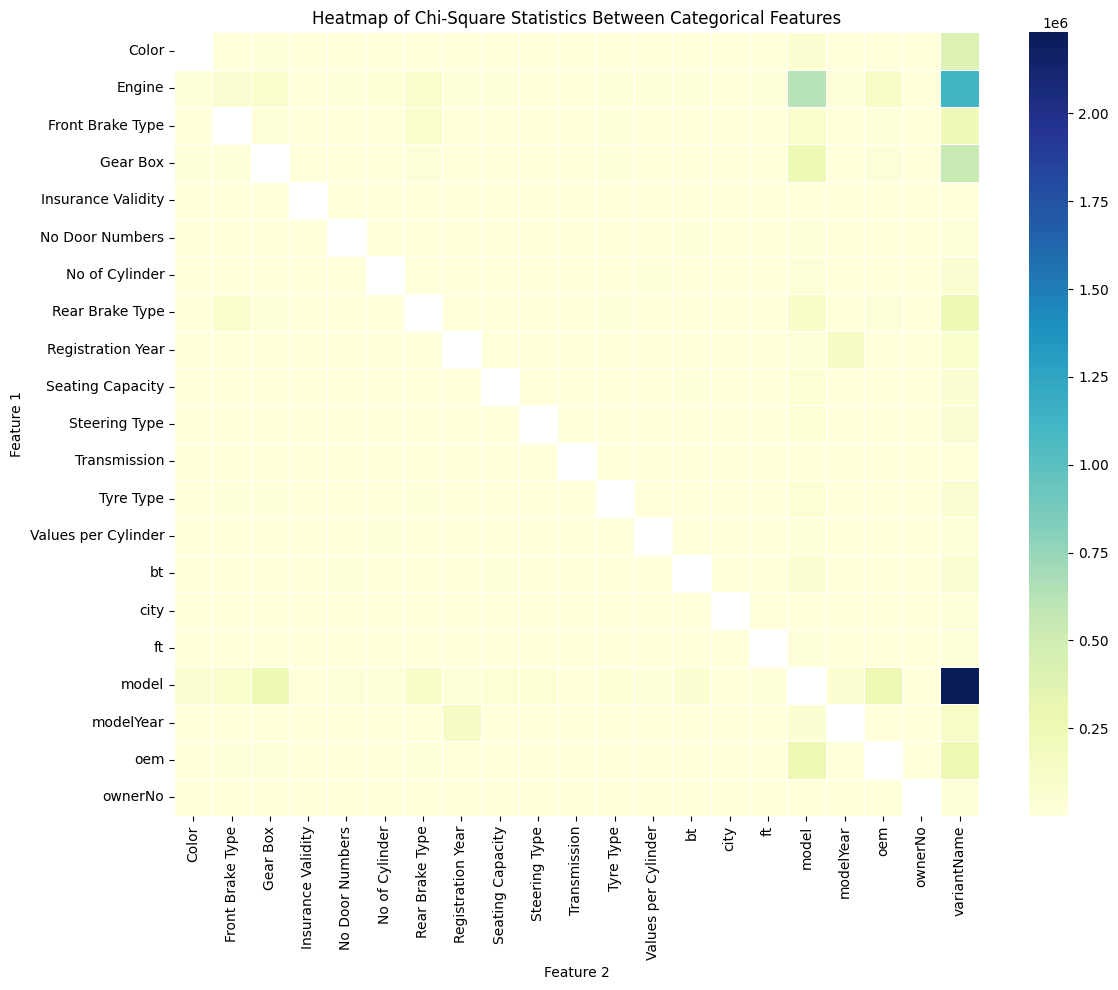

,Feature 1,Feature 2,Chi-Square Statistic,p-value
185,model,variantName,2.230738e+06,0.000000e+00
20,Engine,variantName,1.123329e+06,0.000000e+00
10,Engine,model,6.224695e+05,0.000000e+00
215,Gear Box,variantName,5.321262e+05,0.000000e+00
209,Color,variantName,4.093094e+05,0.000000e+00
165,oem,model,2.678080e+05,0.000000e+00
175,oem,variantName,2.620933e+05,0.000000e+00
227,Rear Brake Type,variantName,2.522295e+05,0.000000e+00
179,model,Gear Box,2.498613e+05,0.000000e+00
224,Front Brake Type,variantName,2.305920e+05,0.000000e+00


In [114]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

# List of all categorical columns
categorical_columns = label_encoding_columns + OneHotEncoding_columns

# Initialize an empty list to store the Chi-Square test results
chi_square_results = []

# Loop through each pair of categorical columns
for i, col1 in enumerate(categorical_columns):
    for j, col2 in enumerate(categorical_columns):
        if i >= j:  # Skip duplicate or self-pair columns
            continue
        
        # Create a contingency table
        contingency_table = pd.crosstab(X[col1], X[col2])

        # Perform the Chi-Square test of independence
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

        # Store the result as a tuple (feature1, feature2, chi-square stat, p-value)
        chi_square_results.append((col1, col2, chi2_stat, p_value))

# Convert the results to a DataFrame for easier visualization
chi_square_df = pd.DataFrame(chi_square_results, columns=['Feature 1', 'Feature 2', 'Chi-Square Statistic', 'p-value'])

# Create a pivot table to transform data into a matrix format
pivot_table = chi_square_df.pivot(index='Feature 1', columns='Feature 2', values='Chi-Square Statistic')

# Since the matrix is symmetric, we can fill NaNs by copying the transpose
pivot_table = pivot_table.fillna(pivot_table.T)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=False, linewidths=0.5)
plt.title("Heatmap of Chi-Square Statistics Between Categorical Features")
plt.xticks(rotation=90)  # Rotate feature names on x-axis
plt.yticks(rotation=0)   # Rotate feature names on y-axis
plt.tight_layout()
plt.show()

# Set a threshold for highly correlated features (p-value or Chi-Square statistic)
chi_square_threshold = 10000  # You can adjust this threshold based on your data

# Filter the DataFrame to get pairs with Chi-Square statistic above the threshold
highly_correlated = chi_square_df[chi_square_df['Chi-Square Statistic'] > chi_square_threshold]

# Sort the result to see the most highly correlated features at the top
highly_correlated = highly_correlated.sort_values(by='Chi-Square Statistic', ascending=False)

highly_correlated

In [115]:
drop_ = ["model","variantName","Registration Year",'Rear Brake Type',"Front Brake Type",'Tyre Type']
for i in drop_:
    drop_columns.append(i)
    try:
        label_encoding_columns.remove(i)
    except:
        OneHotEncoding_columns.remove(i)
    

In [116]:
import pandas as pd
from scipy import stats
from sklearn.preprocessing import LabelEncoder

# Initialize an empty list to store the results
anova_results = []

# Loop through each categorical column
for feature in label_encoding_columns:
    # Get unique categories for the feature
    groups = [y[X[feature] == category] for category in X[feature].unique()]
    
    # Perform ANOVA test
    f_stat, p_value = stats.f_oneway(*groups)
    
    # Store the feature and its F-statistic
    anova_results.append((feature, f_stat))

for feature in OneHotEncoding_columns:
    # Get unique categories for the feature
    groups = [y[X[feature] == category] for category in X[feature].unique()]
    
    # Perform ANOVA test
    f_stat, p_value = stats.f_oneway(*groups)
    
    # Store the feature and its F-statistic
    anova_results.append((feature, f_stat))

# Convert results to a DataFrame for easier sorting
anova_df = pd.DataFrame(anova_results, columns=['Feature', 'F_statistic'])

# Sort the features by F-statistic in descending order
anova_df = anova_df.sort_values(by='F_statistic', ascending=False)

# Select the top 10 features
top_5_features = anova_df.head(13)
last_features = anova_df[13:]
# Print the top 10 features
print(top_5_features['Feature'])
print(last_features['Feature'])


11          Transmission
1         No of Cylinder
9                    oem
0                 Engine
8                     bt
13              Gear Box
7                     ft
10    Insurance Validity
3       Seating Capacity
15                  city
6              modelYear
4        No Door Numbers
5                ownerNo
Name: Feature, dtype: object
2     Values per Cylinder
14          Steering Type
12                  Color
Name: Feature, dtype: object


In [117]:

for i in last_features['Feature']:
    print(i)
    drop_columns.append(i)
    try:
        label_encoding_columns.remove(i)
    except:
        OneHotEncoding_columns.remove(i)

Values per Cylinder
Steering Type
Color


In [118]:
X = X.drop(columns=drop_columns)

In [119]:
X.shape

(8369, 21)

In [ ]:
a=[ft,bt,ownerNo,oem,modelYear,Insurance Validity,Transmission,Mileage,Engine,Max Power,Torque,No of Cylinder,Length,Width,Height,Wheel Base,Kerb Weight,Gear Box,Seating Capacity,No Door Numbers,city]

In [120]:
X

,ft,bt,ownerNo,oem,modelYear,Insurance Validity,Transmission,Mileage,Engine,Max Power,...,No of Cylinder,Length,Width,Height,Wheel Base,Kerb Weight,Gear Box,Seating Capacity,No Door Numbers,city
0,Petrol,Hatchback,3,Maruti,2015,Third Party,Manual,23.10,998.0,67.0,...,3.0,3715.0,1635.0,1565.0,2425.0,835.0,5 Speed,5,5,bangalore
1,Petrol,SUV,2,Ford,2018,Comprehensive,Manual,17.00,1497.0,121.0,...,3.0,3998.0,1765.0,1647.0,2519.0,1242.0,5 Speed,5,4,bangalore
2,Petrol,Hatchback,1,Tata,2018,Comprehensive,Manual,23.84,1199.0,84.0,...,3.0,3746.0,1647.0,1535.0,2400.0,1012.0,5 Speed,5,5,bangalore
3,Petrol,Sedan,1,Hyundai,2014,Comprehensive,Manual,19.10,1197.0,81.0,...,4.0,3995.0,1660.0,1520.0,2425.0,1180.0,5 Speed,5,4,bangalore
4,Diesel,SUV,1,Maruti,2015,Third Party,Manual,23.65,1248.0,88.0,...,4.0,4300.0,1785.0,1595.0,2600.0,1230.0,5 Speed,5,5,bangalore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,Petrol,Hatchback,1,Maruti,2022,Third Party,Manual,25.24,998.0,65.0,...,3.0,3695.0,1655.0,1555.0,2435.0,810.0,5 Speed,5,5,kolkata
8365,Petrol,Hatchback,1,Maruti,2014,Third Party,Manual,22.74,796.0,47.0,...,3.0,3395.0,1490.0,1475.0,2360.0,720.0,5 Speed,5,5,kolkata
8366,Petrol,Sedan,3,Mercedes-Benz,2011,Third Party,Automatic,11.74,1796.0,186.0,...,4.0,4591.0,1770.0,1447.0,2760.0,1585.0,7 Speed,5,4,kolkata
8367,Petrol,Hatchback,1,Maruti,2012,Third Party,Manual,18.50,1197.0,85.0,...,4.0,3775.0,1680.0,1620.0,2360.0,1030.0,5 Speed,5,5,kolkata


In [121]:
X.to_csv('New folder\\finalcsvdata.csv',index=False)

In [122]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import pickle


In [123]:
from sklearn.preprocessing import LabelEncoder

# Assuming label_encode_columns contains the names of columns to be label encoded
for col in label_encoding_columns:
    label_encoder = LabelEncoder()
   

    # Fit the label encoder on the column values
    final_df[col] = label_encoder.fit_transform(final_df[col])
    # Save the model to a file
    with open(f'pickle\\label_encoder_{col}.pkl', 'wb') as file:
        pickle.dump(label_encoder, file)


In [124]:
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
 
X_encoded = pd.DataFrame(onehot_encoder.fit_transform(X[OneHotEncoding_columns]))
 
 
X_encoded.columns = onehot_encoder.get_feature_names_out(OneHotEncoding_columns)
 
 
X_encoded.index = X.index
 
df_encoded = X.drop(columns=OneHotEncoding_columns)
 
 
df_encoded = pd.concat([df_encoded, X_encoded], axis=1)


In [125]:
df_encoded.shape

(8369, 151)

In [126]:
df_encoded.head()

,ownerNo,modelYear,Mileage,Engine,Max Power,Torque,No of Cylinder,Length,Width,Height,...,Gear Box_Six Speed Automatic Gearbox,"Gear Box_Six Speed Geartronic, Six Speed Automati",Gear Box_Six Speed Manual with Paddle Shifter,Gear Box_iMT,city_bangalore,city_chennai,city_delhi,city_hyderabad,city_jaipur,city_kolkata
0,3,2015,23.10,998.0,67.0,90.0,3.0,3715.0,1635.0,1565.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,2018,17.00,1497.0,121.0,150.0,3.0,3998.0,1765.0,1647.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,2018,23.84,1199.0,84.0,114.0,3.0,3746.0,1647.0,1535.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,2014,19.10,1197.0,81.0,113.0,4.0,3995.0,1660.0,1520.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,2015,23.65,1248.0,88.0,200.0,4.0,4300.0,1785.0,1595.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [127]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVR


X = df_encoded
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# List of models to try
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': xgb(),
    'KNN Regressor': KNeighborsRegressor()
}

# Loop through models and evaluate each one
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name}:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  R-squared: {r2}\n")


Linear Regression:
  Mean Squared Error: 8.898456888592615e+34
  R-squared: -2.981267062765285e+22

Random Forest:
  Mean Squared Error: 258107778778.15652
  R-squared: 0.9135256562852743

Gradient Boosting:
  Mean Squared Error: 246329417343.1364
  R-squared: 0.917471783286753

XGBoost:
  Mean Squared Error: 192857746449.42297
  R-squared: 0.9353864789009094

KNN Regressor:
  Mean Squared Error: 970254551354.6501
  R-squared: 0.6749337584407604



In [128]:
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBRegressor

import numpy as np
 
# Define the parameter grid

param_dist = {

    'n_estimators': [100, 200, 300, 500],

    'learning_rate': [0.01, 0.05, 0.1, 0.2],

    'max_depth': [3, 5, 7, 10],

    'subsample': [0.6, 0.8, 1.0],

    'colsample_bytree': [0.6, 0.8, 1.0],

    'gamma': [0, 0.1, 0.5, 1],

    'min_child_weight': [1, 3, 5, 7],

    'reg_alpha': [0, 0.01, 0.1, 1],

    'reg_lambda': [0, 0.01, 0.1, 1]

}
 
# Initialize the model

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
 
# Set up RandomizedSearchCV

random_search = RandomizedSearchCV(

    estimator=xgb,

    param_distributions=param_dist,

    n_iter=50,  # Number of parameter settings sampled

    scoring='neg_mean_squared_error',  # Can also use 'r2' or other metrics

    cv=5,  # 5-fold cross-validation

    verbose=2,

    random_state=42,

    n_jobs=-1  # Use all processors

)
 
# Fit the model

random_search.fit(X_train_scaled, y_train)
 
# Print the best parameters

print(f"Best hyperparameters: {random_search.best_params_}")



 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'subsample': 0.6, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.6}


In [129]:

param_dist = {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 500, 

            'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}
 
model = XGBRegressor (**param_dist)
 
model.fit(X_train_scaled, y_train)
 
    # Predict on the test set

y_pred = model.predict(X_test_scaled)
 
    # Evaluate the model

mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
 


print(f"  Mean Squared Error: {mse}")

print(f"  R-squared: {r2}\n")

  Mean Squared Error: 250662786884.47293
  R-squared: 0.9160199761390686



In [130]:
model = XGBRegressor()
model.fit(X_train_scaled, y_train)

    # Predict on the test set
y_pred = model.predict(X_test_scaled)

    # Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

 
print(f"  Mean Squared Error: {mse}")
print(f"  R-squared: {r2}\n")


  Mean Squared Error: 192857746449.42297
  R-squared: 0.9353864789009094



In [131]:
with open('pickle\\model_xgb.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('pickle\\scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
with open('pickle\\onehot_encoder.pkl', 'wb') as file:
    pickle.dump(onehot_encoder, file)
 